# LSTM Anomaly Detection

In [1]:
!pip install pymongo
!

     |████████████████████████████████| 462 kB 5.1 MB/s eta 0:00:01


In [51]:
from pymongo import MongoClient
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

In [6]:
client = MongoClient("put-mongodb-connection-string-here")

# database
db = client["indycar"]

# print collections(tables) in the indycar database
print(db.list_collection_names())

['laps', 'system.indexes', 'cars', 'telemetry', 'pitstop']


In [7]:
telemetry= db["telemetry"]

In [8]:
first_10 = telemetry.find({}).limit(10)

for rec in first_10:
    print(rec)
    
del first_10

{'_id': ObjectId('5d9cdc66d6468701d4b7863b'), 'file': 'eRPGenerator_TGMLP_20170528_Indianapolis500_Race.log', 'car_number': '21', 'time_of_day_long': 58980010, 'time_of_day': '16:23:00.010', 'engine_speed': 3297.0, 'lap_distance': 2703.21, 'throttle': 4.0, 'vehicle_speed': 62.16, 'series': 'Indy500', 'year': '2017'}
{'_id': ObjectId('5d9cdc66d6468701d4b7863c'), 'file': 'eRPGenerator_TGMLP_20170528_Indianapolis500_Race.log', 'car_number': '50', 'time_of_day_long': 58980019, 'time_of_day': '16:23:00.019', 'engine_speed': 5187.0, 'lap_distance': 1873.8, 'throttle': 20.0, 'vehicle_speed': 63.0, 'series': 'Indy500', 'year': '2017'}
{'_id': ObjectId('5d9cdc66d6468701d4b7863d'), 'file': 'eRPGenerator_TGMLP_20170528_Indianapolis500_Race.log', 'car_number': '63', 'time_of_day_long': 58980023, 'time_of_day': '16:23:00.023', 'engine_speed': 4914.0, 'lap_distance': 1822.53, 'throttle': 73.0, 'vehicle_speed': 58.0, 'series': 'Indy500', 'year': '2017'}
{'_id': ObjectId('5d9cdc66d6468701d4b7863e'), '

In [9]:
car_numbers_2017 = list(telemetry.find({'year':'2017', 'series':'Indy500'}, {"car_number":1, "_id":0}).distinct("car_number"))
print(car_numbers_2017)

car_numbers_2018 = list(telemetry.find({'year':'2018', 'series':'Indy500'}, {"car_number":1, "_id":0}).distinct("car_number"))
print(car_numbers_2018)

['21', '50', '63', '77', '1', '2', '4', '8', '9', '11', '12', '18', '19', '20', '24', '40', '44', '88', '98', '912', '916', '0', '15', '28', '911', '10', '14', '26', '29', '913', '7', '17', '22', '27', '3', '83', '5', '16']
['19', '22', '23', '24', '26', '27', '29', '32', '33', '59', '60', '64', '88', 'S1', 'S3', '1', '4', '6', '7', '10', '13', '14', '15', '17', '18', '20', '21', '25', '98', 'S2', '3', '9', '28', '12', '30', '66', '437']


Car numbers are between 1 and 99. Therefore, I removed other values.

In [10]:
car_numbers= {}
car_numbers['2017'] = ['21', '50', '63', '77', '1', '2', '4', '8', '9', '11', '12', '18', '19', '20', '24', '40', '44', '88', '98', '15', '28', '10', '14', '26', '29', '7', '17', '22', '27', '3', '83', '5', '16']
car_numbers['2018']= ['19', '22', '23', '24', '26', '27', '29', '32', '33', '59', '60', '64', '88', '1', '4', '6', '7', '10', '13', '14', '15', '17', '18', '20', '21', '25', '98', '3', '9', '28', '12', '30', '66']

# Speed Model

In [11]:
speed_data =list(telemetry.find({'series':'Indy500'}, {"car_number":1, "time_of_day":1, "year":1, "vehicle_speed":1, "_id":0}))
#car_12_list.values()
df = pd.DataFrame(speed_data)
df

,car_number,time_of_day,vehicle_speed,year
0,21,16:23:00.010,62.16,2017
1,50,16:23:00.019,63.00,2017
2,63,16:23:00.023,58.00,2017
3,77,16:23:00.034,77.52,2017
4,1,16:23:00.064,60.83,2017
...,...,...,...,...
5939908,88,19:25:06.649,0.00,2018
5939909,98,19:25:06.657,0.00,2018
5939910,S1,19:25:06.661,0.00,2018
5939911,S2,19:25:06.579,0.00,2018


In [12]:
df.dtypes

car_number        object
time_of_day       object
vehicle_speed    float64
year              object
dtype: object

scale data between 0 and 1

In [13]:
speedmax = np.round(df.vehicle_speed.max())
speedmin = 0
print('speed min: %d, speed max: %d' % (speedmin, speedmax))
df['speed_scaled'] = (df['vehicle_speed'] - speedmin) / (speedmax - speedmin)
df

speed min: 0, speed max: 239


,car_number,time_of_day,vehicle_speed,year,speed_scaled
0,21,16:23:00.010,62.16,2017,0.260084
1,50,16:23:00.019,63.00,2017,0.263598
2,63,16:23:00.023,58.00,2017,0.242678
3,77,16:23:00.034,77.52,2017,0.324351
4,1,16:23:00.064,60.83,2017,0.254519
...,...,...,...,...,...
5939908,88,19:25:06.649,0.00,2018,0.000000
5939909,98,19:25:06.657,0.00,2018,0.000000
5939910,S1,19:25:06.661,0.00,2018,0.000000
5939911,S2,19:25:06.579,0.00,2018,0.000000


In [36]:
# https://www.tensorflow.org/tutorials/structured_data/time_series
def generate_timeseries_data(data_df, car_numbers, history_size=150, target_size=1, col_name="speed_scaled", years=['2017', '2018'], train_ratio=0.2):
    X,y = [], []
    for year in years:
        for car_num in car_numbers[year]:
            car_data = data_df[(data_df['car_number'] == car_num) & (data_df['year'] == year)][col_name].values
            train_size = int(len(car_data) * train_ratio)
            
            for i in range(history_size, train_size - history_size):
                indices = range(i-history_size, i)
                #Reshape data from (history_size,) to (history_size, 1)
                X.append(np.reshape(car_data[indices], (history_size, 1)))
                y.append(car_data[i+target_size])

    return np.array(X), np.array(y)

In [37]:
trainX, trainy = generate_timeseries_data(df, car_numbers, history_size=150, target_size=1, col_name="speed_scaled", years=['2017', '2018'], train_ratio=0.2)

['21', '50', '63', '77', '1', '2', '4', '8', '9', '11', '12', '18', '19', '20', '24', '40', '44', '88', '98', '15', '28', '10', '14', '26', '29', '7', '17', '22', '27', '3', '83', '5', '16']
['19', '22', '23', '24', '26', '27', '29', '32', '33', '59', '60', '64', '88', '1', '4', '6', '7', '10', '13', '14', '15', '17', '18', '20', '21', '25', '98', '3', '9', '28', '12', '30', '66']


In [39]:
# https://www.curiousily.com/posts/anomaly-detection-in-time-series-with-lstms-using-keras-in-python/
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64,
    input_shape=(trainX.shape[1], trainX.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=trainX.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(
  keras.layers.TimeDistributed(
    keras.layers.Dense(units=trainX.shape[2])
  )
)
model.compile(loss='mae', optimizer='adam')

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 150, 64)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 150, 64)           33024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 150, 64)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 150, 1)            65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
__________________________________________________

In [45]:
callbacks = [EarlyStopping(verbose=True, patience=5, monitor="val_loss"),
             ModelCheckpoint("/scratch/LSTM-AD-IndyCar/checkpoints/speed", monitor="val_loss", verbose=True, save_best_only=True)]
history = model.fit(trainX, trainy, epochs=20, batch_size=32, callbacks=callbacks, validation_split=0.1, shuffle=True)

Train on 917787 samples, validate on 101977 samples
Epoch 1/20
917760/917787 [============================>.] - ETA: 0s - loss: 0.0098
Epoch 00001: val_loss improved from inf to 0.00595, saving model to /scratch/LSTM-AD-IndyCar/checkpoints/speed
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /scratch/LSTM-AD-IndyCar/checkpoints/speed/assets
917787/917787 [==============================] - 1628s 2ms/sample - loss: 0.0098 - val_loss: 0.0059
Epoch 2/20
917760/917787 [============================>.] - ETA: 0s - loss: 0.0086
Epoch 00002: val_loss improved from 0.00595 to 0.00547, saving model to /scratch/LSTM-AD-IndyCar/checkpoints/speed
INFO:tensorflow:Assets written to: /scratch/LSTM-AD-IndyCar/checkpoints/speed/assets
917787/917787 [==============================] - 1627s 2ms/sample - loss: 0.0086 - val_loss: 0.0055
Epoch 3/20
917760/917787 [============================>.] - ETA: 0s - loss: 0.0083
Epoch 00003: val_loss 

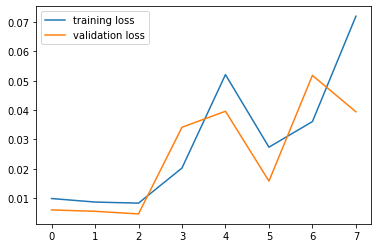

In [55]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss', 'validation loss'])

Load best model from checkpoint

In [56]:
best_speed_model = tf.keras.models.load_model('/scratch/LSTM-AD-IndyCar/checkpoints/speed/')

In [58]:
car12_X, car12_y = generate_timeseries_data(df, {'2017':['12']}, history_size=150, target_size=1, col_name="speed_scaled", years=['2017'], train_ratio=1)

['12']


In [60]:
car12_pred = best_speed_model.predict(car12_X)

In [61]:
car12_pred.shape

(96750, 150, 1)

In [64]:
car12_y.shape

(96750,)

In [62]:
train_mae_loss = np.mean(np.abs(car12_pred - car12_X), axis=1)

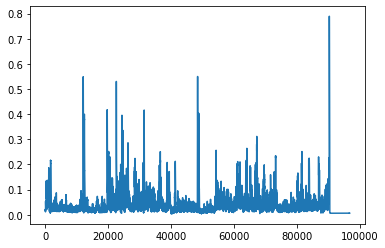

In [63]:
plt.plot(train_mae_loss)

In [67]:
export_path = 'serve_model/speed/1/'
best_speed_model.save('lstm-ad-speed_model.h5')

tf.keras.models.save_model(
    best_speed_model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

INFO:tensorflow:Assets written to: serve_model/speed/1/assets


In [68]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['lstm_2_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 150, 1)
        name: serving_default_lstm_2_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['time_distributed_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 150, 1)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Defined Functions:
  Functi

# RPM Model

In [69]:
df =list(telemetry.find({'series':'Indy500'}, {"car_number":1, "time_of_day":1, "year":1, "engine_speed":1, "_id":0}))
df = pd.DataFrame(df)
df

,car_number,time_of_day,engine_speed,year
0,21,16:23:00.010,3297.0,2017
1,50,16:23:00.019,5187.0,2017
2,63,16:23:00.023,4914.0,2017
3,77,16:23:00.034,6744.0,2017
4,1,16:23:00.064,3356.0,2017
...,...,...,...,...
5939908,88,19:25:06.649,0.0,2018
5939909,98,19:25:06.657,0.0,2018
5939910,S1,19:25:06.661,0.0,2018
5939911,S2,19:25:06.579,0.0,2018


In [70]:
rpmmax = np.round(df.engine_speed.max())
rpmmin = 0
print('rpm min: %d, rpm max: %d' % (rpmmin, rpmmax))
df['rpm_scaled'] = (df['engine_speed'] - rpmmin) / (rpmmax - rpmmin)
df

rpm min: 0, rpm max: 13217


,car_number,time_of_day,engine_speed,year,rpm_scaled
0,21,16:23:00.010,3297.0,2017,0.249451
1,50,16:23:00.019,5187.0,2017,0.392449
2,63,16:23:00.023,4914.0,2017,0.371794
3,77,16:23:00.034,6744.0,2017,0.510252
4,1,16:23:00.064,3356.0,2017,0.253915
...,...,...,...,...,...
5939908,88,19:25:06.649,0.0,2018,0.000000
5939909,98,19:25:06.657,0.0,2018,0.000000
5939910,S1,19:25:06.661,0.0,2018,0.000000
5939911,S2,19:25:06.579,0.0,2018,0.000000


In [71]:
trainX, trainy = generate_timeseries_data(df, car_numbers, history_size=150, target_size=1, col_name="rpm_scaled", years=['2017', '2018'], train_ratio=0.2)

['21', '50', '63', '77', '1', '2', '4', '8', '9', '11', '12', '18', '19', '20', '24', '40', '44', '88', '98', '15', '28', '10', '14', '26', '29', '7', '17', '22', '27', '3', '83', '5', '16']
['19', '22', '23', '24', '26', '27', '29', '32', '33', '59', '60', '64', '88', '1', '4', '6', '7', '10', '13', '14', '15', '17', '18', '20', '21', '25', '98', '3', '9', '28', '12', '30', '66']


In [72]:
model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 150, 64)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 150, 64)           33024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 150, 64)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 150, 1)            65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
__________________________________________________

In [74]:
callbacks = [EarlyStopping(verbose=True, patience=3, monitor="val_loss"),
             ModelCheckpoint("/scratch/LSTM-AD-IndyCar/checkpoints/rpm", monitor="val_loss", verbose=True, save_best_only=True)]
history = model.fit(trainX, trainy, epochs=20, batch_size=32, callbacks=callbacks, validation_split=0.1, shuffle=True)

Train on 917787 samples, validate on 101977 samples
Epoch 1/20
917760/917787 [============================>.] - ETA: 0s - loss: 0.0550
Epoch 00001: val_loss improved from inf to 0.05713, saving model to /scratch/LSTM-AD-IndyCar/checkpoints/rpm
INFO:tensorflow:Assets written to: /scratch/LSTM-AD-IndyCar/checkpoints/rpm/assets
917787/917787 [==============================] - 1629s 2ms/sample - loss: 0.0550 - val_loss: 0.0571
Epoch 2/20
917760/917787 [============================>.] - ETA: 0s - loss: 0.0458
Epoch 00002: val_loss improved from 0.05713 to 0.01465, saving model to /scratch/LSTM-AD-IndyCar/checkpoints/rpm
INFO:tensorflow:Assets written to: /scratch/LSTM-AD-IndyCar/checkpoints/rpm/assets
917787/917787 [==============================] - 1626s 2ms/sample - loss: 0.0458 - val_loss: 0.0147
Epoch 3/20
917760/917787 [============================>.] - ETA: 0s - loss: 0.0139
Epoch 00003: val_loss improved from 0.01465 to 0.01057, saving model to /scratch/LSTM-AD-IndyCar/checkpoints/rp

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



917760/917787 [============================>.] - ETA: 0s - loss: 0.0104
Epoch 00004: val_loss did not improve from 0.01057
917787/917787 [==============================] - 1622s 2ms/sample - loss: 0.0104 - val_loss: 0.0129
Epoch 5/20
682144/917787 [=====================>........] - ETA: 6:40 - loss: 0.0218

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



866528/917787 [===========================>..] - ETA: 1:27 - loss: 0.0257

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



917760/917787 [============================>.] - ETA: 0s - loss: 0.0272
Epoch 00005: val_loss did not improve from 0.01057
917787/917787 [==============================] - 1622s 2ms/sample - loss: 0.0272 - val_loss: 0.0438
Epoch 6/20
917760/917787 [============================>.] - ETA: 0s - loss: 0.0655
Epoch 00006: val_loss did not improve from 0.01057
917787/917787 [==============================] - 1620s 2ms/sample - loss: 0.0655 - val_loss: 0.0545
Epoch 00006: early stopping


In [78]:
best_rpm_model = tf.keras.models.load_model('/scratch/LSTM-AD-IndyCar/checkpoints/rpm/')

['12']


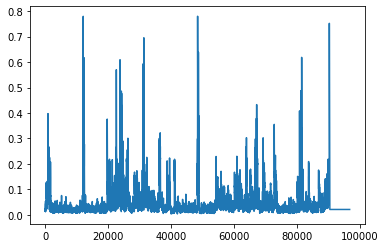

In [79]:
car12_X, car12_y = generate_timeseries_data(df, {'2017':['12']}, history_size=150, target_size=1, col_name="rpm_scaled", years=['2017'], train_ratio=1)
car12_pred = best_rpm_model.predict(car12_X)
train_mae_loss = np.mean(np.abs(car12_pred - car12_X), axis=1)
plt.plot(train_mae_loss)

In [80]:
export_path = 'serve_model/rpm/1/'
best_speed_model.save('lstm-ad-rpm_model.h5')

tf.keras.models.save_model(
    best_speed_model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

INFO:tensorflow:Assets written to: serve_model/rpm/1/assets


In [81]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['lstm_2_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 150, 1)
        name: serving_default_lstm_2_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['time_distributed_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 150, 1)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Defined Functions:
  Functi

# Throttle Model

In [82]:
df =list(telemetry.find({'series':'Indy500'}, {"car_number":1, "time_of_day":1, "year":1, "throttle":1, "_id":0}))
df = pd.DataFrame(df)
df

,car_number,time_of_day,throttle,year
0,21,16:23:00.010,4.0,2017
1,50,16:23:00.019,20.0,2017
2,63,16:23:00.023,73.0,2017
3,77,16:23:00.034,24.0,2017
4,1,16:23:00.064,9.5,2017
...,...,...,...,...
5939908,88,19:25:06.649,0.0,2018
5939909,98,19:25:06.657,5.5,2018
5939910,S1,19:25:06.661,0.0,2018
5939911,S2,19:25:06.579,0.0,2018


In [83]:
throttlemax = np.round(df.throttle.max())
throttlemin = 0
print('throttle min: %d, throttle max: %d' % (throttlemin, throttlemax))
df['throttle_scaled'] = (df['throttle'] - throttlemin) / (throttlemax - throttlemin)
df

throttle min: 0, throttle max: 117


,car_number,time_of_day,throttle,year,throttle_scaled
0,21,16:23:00.010,4.0,2017,0.034188
1,50,16:23:00.019,20.0,2017,0.170940
2,63,16:23:00.023,73.0,2017,0.623932
3,77,16:23:00.034,24.0,2017,0.205128
4,1,16:23:00.064,9.5,2017,0.081197
...,...,...,...,...,...
5939908,88,19:25:06.649,0.0,2018,0.000000
5939909,98,19:25:06.657,5.5,2018,0.047009
5939910,S1,19:25:06.661,0.0,2018,0.000000
5939911,S2,19:25:06.579,0.0,2018,0.000000


In [84]:
trainX, trainy = generate_timeseries_data(df, car_numbers, history_size=150, target_size=1, col_name="throttle_scaled", years=['2017', '2018'], train_ratio=0.2)

['21', '50', '63', '77', '1', '2', '4', '8', '9', '11', '12', '18', '19', '20', '24', '40', '44', '88', '98', '15', '28', '10', '14', '26', '29', '7', '17', '22', '27', '3', '83', '5', '16']
['19', '22', '23', '24', '26', '27', '29', '32', '33', '59', '60', '64', '88', '1', '4', '6', '7', '10', '13', '14', '15', '17', '18', '20', '21', '25', '98', '3', '9', '28', '12', '30', '66']


In [85]:
model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 150, 64)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 150, 64)           33024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 150, 64)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 150, 1)            65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
__________________________________________________

In [ ]:
callbacks = [EarlyStopping(verbose=True, patience=3, monitor="val_loss"),
             ModelCheckpoint("/scratch/LSTM-AD-IndyCar/checkpoints/throttle", monitor="val_loss", verbose=True, save_best_only=True)]
history = model.fit(trainX, trainy, epochs=20, batch_size=32, callbacks=callbacks, validation_split=0.1, shuffle=True)

Train on 917787 samples, validate on 101977 samples
Epoch 1/20
164800/917787 [====>.........................] - ETA: 21:33 - loss: 0.1561

In [ ]:
best_throttle_model = tf.keras.models.load_model('/scratch/LSTM-AD-IndyCar/checkpoints/throttle/')

In [ ]:
car12_X, car12_y = generate_timeseries_data(df, {'2017':['12']}, history_size=150, target_size=1, col_name="throttle_scaled", years=['2017'], train_ratio=1)
car12_pred = best_throttle_model.predict(car12_X)
train_mae_loss = np.mean(np.abs(car12_pred - car12_X), axis=1)
plt.plot(train_mae_loss)

In [ ]:
export_path = 'serve_model/throttle/1/'
best_speed_model.save('lstm-ad-throttle_model.h5')

tf.keras.models.save_model(
    best_speed_model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

In [ ]:
!saved_model_cli show --dir {export_path} --all